In [4]:
import pandas as pd

data = pd.read_csv("/content/tutorial_dataset.csv")

Show dataset columns

Dataset may attendance 60% say kam wala student exam may ni bheth sakhta

In [5]:
data.head()

,StudyHours,SleepHours,Attendance,TestScore
0,20.000000,8.399355,84.0,77.246146
1,4.792604,7.924634,85.0,86.066612
2,5.971533,7.059630,NaN,82.692611
3,7.284545,6.353063,NaN,76.164641
4,4.648770,7.698223,NaN,NaN


Sabse pehla kaam? Check karo kahin NaN to nahi hai.

In [ ]:
data.isnull().sum()

,0
StudyHours,50
SleepHours,50
Attendance,50
TestScore,158


Check skewness first. We are checking skewness because all columns are continous and not categorial. In case of categorical columns we don't check skewness

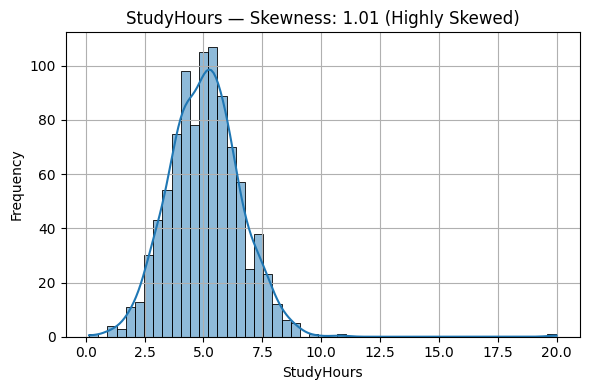

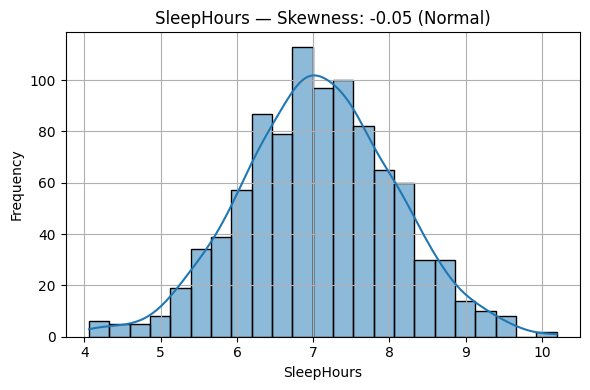

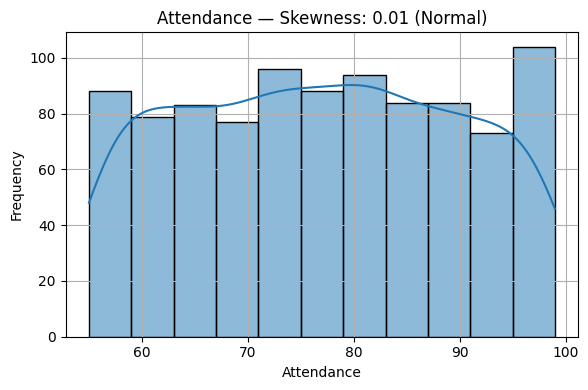

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

input_cols = data.drop(columns=['TestScore']).select_dtypes(include='number').columns

for col in input_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col].dropna(), kde=True)
    skew_val = data[col].skew()

    # Interpretation
    if abs(skew_val) < 0.5:
        skew_type = "Normal"
    elif abs(skew_val) < 1:
        skew_type = "Slightly Skewed"
    else:
        skew_type = "Highly Skewed"

    plt.title(f"{col} — Skewness: {skew_val:.2f} ({skew_type})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Industry Practice (Used in Kaggle, Papers, Production Pipelines):

Condition   Best Imputation

Skewness between -0.5 to 0.5    mean (symmetric)
Skewness > 0.5 or < -0.5    median (skewed)


These thresholds are standard but can be slightly adjusted.

In [ ]:
col_median = data["StudyHours"].median()
data["StudyHours"] = data["StudyHours"].fillna(col_median)

In [ ]:
col_mean = data["SleepHours"].mean()
data["SleepHours"] = data["SleepHours"].fillna(col_mean)

In [ ]:
col_mean = data["Attendance"].mean()
data["Attendance"] = data["Attendance"].fillna(col_mean)

### OUTLIER DETECTION
Z-score isliye use kar rahe hain kyunki humein outliers detect karne hain — yani aisi values jo baaki data se bohot zyada alag hain.

🤔 Matlab kya?
Maan lo:
Baaki students roz 5-6 ghante parte hain
Lekin ek student 20 ghante padh raha hai

Toh yeh value unusual hai — isse model galat seekh sakta hai, kyunki woh sochta hai "zyada padho, toh score explode ho jaayega"


✅ Z-Score se kya hota hai?
Z-score batata hai:
"Yeh value average se kitni door hai?"
Agar distance 3 standard deviations se zyada hai, toh yeh outlier hai


💡 Isliye Z-score:
Simple hai, fast hai
Har numeric column pe kaam karta hai
Automatically normalize karta hai values ko
Threshold fixed hai (usually > 3 ya < -3)


Agar Z-score na use karein:

Humein har feature ke liye manually dekhna padega kaunsi value odd lag rahi hai
Jo practical nahi hai — especially jab 100+ columns hoon


🎯 Final Point:
Z-score ek best practice hai jab aapka data normally distributed ho ya approximately symmetric ho.

Chaaho toh next step mein z-score visualize bhi kara du histogram ke saath.

In [ ]:
from scipy.stats import zscore
import numpy as np

# ✅ Step 1: Define symmetric columns
symmetric_cols = ["SleepHours", "Attendance"]

# ✅ Step 2: Compute Z-scores (data already has no NaNs)
z_scores = np.abs(zscore(data[symmetric_cols]))

# ✅ Step 3: Identify outliers (Z > 3)
outlier_mask = z_scores > 3

# ✅ Step 4: Get index of rows with any outlier
rows_with_outliers = data.index[outlier_mask.any(axis=1)]

# ✅ Step 5: Print full rows that are outliers
for i, col in enumerate(symmetric_cols):
    outlier_indices = data.index[outlier_mask[:, i]]
    if not outlier_indices.empty:
        print(f"\n🔍 Outliers in column: '{col}'")
        print(data.loc[outlier_indices])

# ✅ Step 6: Drop outlier rows from dataset
data = data.drop(index=rows_with_outliers)

For asymmetric (skewed) columns, you should not use Z-score because it assumes normal (symmetric) distribution. Instead, industry-standard practice is to use IQR (Interquartile Range) to detect outliers in skewed data.

In [ ]:

# ✅ Outlier Removal for Skewed Column
skewed_col = "StudyHours"  # replace if needed

Q1 = data[skewed_col].quantile(0.25)
Q3 = data[skewed_col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# ✅ Identify and print outlier rows
outlier_indices = data[(data[skewed_col] < lower_bound) | (data[skewed_col] > upper_bound)].index
if not outlier_indices.empty:
    print(f"\n🔍 Outliers in skewed column: '{skewed_col}'")
    print(data.loc[outlier_indices])

# ✅ Remove outlier rows
data = data.drop(index=outlier_indices)


🔍 Outliers in skewed column: 'StudyHours'
     StudyHours  SleepHours  Attendance   TestScore
0     20.000000    8.399355   84.000000   77.246146
74     1.070382    7.996267   88.000000   66.268980
179    9.080254    5.896411   61.000000   77.111928
209   10.779097    8.749577   89.000000   95.887644
262    0.138099    7.538756   94.000000   71.275482
478    9.618321    6.112508   94.000000  105.449549
544    1.292533    6.397788   90.000000   58.148321
646    0.954670    6.812856   61.000000   50.707229
654    8.860040    7.338484   87.000000   97.035489
668    1.023545    7.064670   76.810526   67.670060
755    8.948573    8.373659   80.000000   92.317808
762    8.840127    7.075434   90.000000  102.961424
880    8.790399    7.964852   82.000000   90.371887


MULTI-LINEAR REGRESSION TRAINING

"Ab model banate hain. Yeh multi-linear regression hai... kyunki teen features hain!"

Explain formula: y = β₀ + β₁X₁ + β₂X₂ + β₃X₃

Yeh beta values seekh leta hai model, aur fir har naye input pe test score batata hai.

In [ ]:
# ✅ Drop rows where 'Attendance' is below 60%
data = data[data["Attendance"] >= 60]

# ✅ Then drop rows where TestScore is NaN (still needed before training)
data = data.dropna(subset=["TestScore"])

# ✅ Redefine X and y for model training
X = data.drop("TestScore", axis=1)
y = data["TestScore"]

# ✅ Train model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

LinearRegression()

PREDICTION & DEMO

Ek naye student ka data dekhte hain... aur model kya predict karta hai

Use these test cases to verify different paths and ensure your logic, validation, and model prediction work as expected:


✅ Valid input (eligible)

Study Hours: 5

Sleep Hours: 7

Attendance (%): 85


Expect a predicted score based on model.


---

❌ Ineligible student (attendance below 60%)

Study Hours: 4

Sleep Hours: 6.5

Attendance (%): 55


Expect:
❌ Student is not eligible for the exam (attendance below 60%).


---

❌ Invalid input (non-numeric)

Study Hours: five

Sleep Hours: seven

Attendance (%): eighty


Expect:
❌ Invalid input. Please enter numeric values.


---

✅ Edge case (just eligible)

Study Hours: 3

Sleep Hours: 6

Attendance (%): 60


Expect:
Predicted score should be returned.

In [ ]:
try:
    study_hours = float(input("Enter Study Hours: "))
    sleep_hours = float(input("Enter Sleep Hours: "))
    attendance = float(input("Enter Attendance (%): "))

    if attendance < 60:
        print("❌ Student is not eligible for the exam (attendance below 60%).")
    else:
        import pandas as pd
        student_df = pd.DataFrame([[study_hours, sleep_hours, attendance]],
                                  columns=["StudyHours", "SleepHours", "Attendance"])
        predicted_score = model.predict(student_df)
        print(f"✅ Predicted Test Score: {predicted_score[0]:.2f}")

except ValueError:
    print("❌ Invalid input. Please enter numeric values.")

Enter Study Hours: 7
Enter Sleep Hours: 8
Enter Attendance (%): 80
✅ Predicted Test Score: 84.20
